In [1]:
from estimador import *
from filtros import *
from fit_voc import *
from functions import *
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import csv

### Obtenemos el Ground Truth

In [2]:
# Obtenemos el ground truth
gt_path = "C:/Users/Bruno/OneDrive - Universidad de Chile/BGMG/CASE/Datasets/Dataset Stanford/W10/W9_diagnostics.csv"
gt_path_values = pd.read_csv(gt_path)
gt_path_values = gt_path_values.values

path = os.path.join('C:/Users/Bruno/Dropbox','Dataset Stanford', 'W10')
files = os.listdir(path)
files.sort(key=lambda x: int(x[1 : x.find(".")]))
# files.remove('C7.csv')

# Combine files and soh values into a df
data_values = [[file, SOH] for file, SOH in zip(files, gt_path_values[1:])]
column_names = ['file', 'SOH']
gt_df = pd.DataFrame(data_values, columns=column_names)

In [3]:
gt_df

,file,SOH
0,C1.csv,"[0.991863254544956, 0.993366442794809]"
1,C2.csv,"[0.978999435744508, 0.979202777943039]"
2,C3.csv,"[0.968953871712516, 0.966177153218522]"
3,C4.csv,"[0.955331494914005, 0.954700824505024]"
4,C5.csv,"[0.952443738391627, 0.952462357447398]"
5,C6.csv,"[0.943475426811888, 0.94369075552298]"
6,C7.csv,"[0.935122234041721, 0.935875415438056]"
7,C8.csv,"[0.932701712420994, 0.933866292647451]"
8,C9.csv,"[0.932777550749221, 0.933685974510152]"
9,C10.csv,"[0.930311190829814, 0.930634649045392]"


In [3]:
EQ_cycles = []
subcycles = [   25,
                50,
                47,
                22,
                1,
                1,
                4,
                29,
                37,
                25,
                25,
                25,
                25,
                25]
SR_0 = 100
SR = 80
acc_subc = 0
for idx,subcycle in enumerate(subcycles):
    eq_cycle = subcycle*(SR/SR_0)
    acc_subc += eq_cycle
    EOL_0 = gt_df["SOH"].values[idx][0]
    eta_0 = EOL_0**(1/acc_subc)
    eq_cycle08 = 1/log_a(0.8,eta_0)
    EQ_cycles.append(eq_cycle08)

gt_df["eq_cycles08"] = EQ_cycles
gt_df

,file,SOH,eq_cycles08
0,C1.csv,"[0.991863254544956, 0.993366442794809]",546.249075
1,C2.csv,"[0.978999435744508, 0.979202777943039]",630.817887
2,C3.csv,"[0.968953871712516, 0.966177153218522]",690.551798
3,C4.csv,"[0.955331494914005, 0.954700824505024]",562.535890
4,C5.csv,"[0.952443738391627, 0.952462357447398]",531.247925
5,C6.csv,"[0.943475426811888, 0.94369075552298]",447.936497
6,C7.csv,"[0.935122234041721, 0.935875415438056]",399.195198
7,C8.csv,"[0.932701712420994, 0.933866292647451]",458.651230
8,C9.csv,"[0.932777550749221, 0.933685974510152]",554.102890
9,C10.csv,"[0.930311190829814, 0.930634649045392]",595.575562


In [4]:
eta_0 = EOL_0**(1/acc_subc)
eq_cycle08 = 1/log_a(0.8,eta_0)
eq_cycle08

691.6526655604366

In [5]:
gt_df["eq_cycles08"][12]

680.3007493808283

### Definimos los modelos a usar

In [6]:
param = dict(
    vL=1.35531394,
    v0=4.12017677,
    gamma=0.13286143,
    alpha=0.16945463,
    beta=2.34538224,
    Qmax=4.850,
    # Qmax=df.SoH.max(),
    Bias_Rint=0.01454392,
    Factor_Rint=0.1879029,
    life_cycles=938,
    # life_cycles=1170,
    # life_cycles=300,
    adapt_cell=True,
    degradation_percentage=0.8
)
f_adap = FiltrosAnidados()
f_adap.Q_inst = param.get("Qmax")
f_adap.fit_batt_model(param)
f_adap.modelo_th.fit_inverse()
f_adap.voc_thresh = 0.05
f_adap.voc_times = 47
f_adap.sigma_autonomia = 0.04
f_adap.sigma_capacidad = 0.001 * 5
f_adap.estim_kwargs = {"sigma_e": 0.00075}

if f_adap.modelo_th.parameters["adapt_cell"]:
    f_adap.modelo_th.adapt_degradation()
    f_adap.modelo_th.setup_knn()
    print("celda: f_adap adaptada")

modelo de celda seteado. Tabla de degradación:  {'100-0': [1.0], '100-25': [1.00000266], '75-0': [1.0000186], '100-50': [0.99999203], '75-25': [1.00001521], '50-0': [1.00002874], '100-75': [1.00002146], '75-50': [1.00000881], '62.5-37.5': [1.0000062], '50-25': [1.00003347], '25-0': [1.00004184]}
Parámetros del modelo:
{'A_Rint': 0.3084,
 'B_Rint': -0.2578,
 'Bias_Rint': 0.01454392,
 'C_Rint': -0.05083,
 'D_Rint': 0.1317,
 'Factor_R_SOH0': 0.28371948548,
 'Factor_R_SOH1': -0.57276721458,
 'Factor_R_SOH2': 0.32037195027000004,
 'Factor_R_SOH3': 0.02140399288,
 'Factor_Rint': 0.1879029,
 'Qmax': 4.85,
 'adapt_cell': True,
 'alpha': 0.16945463,
 'beta': 2.34538224,
 'degradation_data': {'100-0': [1.0],
                      '100-25': [1.00000266],
                      '100-50': [0.99999203],
                      '100-75': [1.00002146],
                      '25-0': [1.00004184],
                      '50-0': [1.00002874],
                      '50-25': [1.00003347],
                     

In [7]:
param["life_cycles"] = gt_df["eq_cycles08"][12]
# param["life_cycles"] = 938
f_adap.fit_batt_model(param)


f_adap.modelo_th.parameters["degradation_data"] = {
            "100-0":        [1.0],
            "100-25":       [1.00000266],
            "75-0":         [1.0000186],
            "100-50":       [0.99999203],
            "75-25":        [1.00001521],
            "50-0":         [1.00002874],
            "100-75":       [1.00002146],
            "75-50":        [1.00000881],
            "62.5-37.5":    [1.00000620],
            "50-25":        [1.00003347],
            "25-0":         [1.00004184],
        }
f_adap.modelo_th.adapt_degradation()
f_adap.modelo_th.setup_knn()
print("celda: f_adap adaptada")
f_adap.modelo_th.parameters["degradation_data"]

Parámetros del modelo:
{'A_Rint': 0.3084,
 'B_Rint': -0.2578,
 'Bias_Rint': 0.01454392,
 'C_Rint': -0.05083,
 'D_Rint': 0.1317,
 'Factor_R_SOH0': 0.28371948548,
 'Factor_R_SOH1': -0.57276721458,
 'Factor_R_SOH2': 0.32037195027000004,
 'Factor_R_SOH3': 0.02140399288,
 'Factor_Rint': 0.1879029,
 'Qmax': 4.85,
 'adapt_cell': True,
 'alpha': 0.16945463,
 'beta': 2.34538224,
 'degradation_data': {'100-0': [1.0],
                      '100-25': [0.9999358287797722],
                      '100-50': [0.9996941791763502],
                      '100-75': [0.9996524331891773],
                      '25-0': [0.9999999950338626],
                      '50-0': [1.0000072208627444],
                      '50-25': [0.9998572387460802],
                      '62.5-37.5': [0.9993922626134676],
                      '75-0': [1.0000264586588516],
                      '75-25': [0.9998918347663978],
                      '75-50': [0.9994367564692109]},
 'degradation_percentage': 0.8,
 'gamma': 0.13286143,


{'100-0': [1.0],
 '100-25': [0.9999292167111458],
 '75-0': [1.0000291850401244],
 '100-50': [0.9996626722370896],
 '75-25': [0.9998806899168797],
 '50-0': [1.0000079649146705],
 '100-75': [0.9996166262285948],
 '75-50': [0.9993787370088608],
 '62.5-37.5': [0.9993296613984834],
 '50-25': [0.9998425295620206],
 '25-0': [0.999999994522144]}

### Tomamos el GT de la celda a analizar (W10)

In [8]:
# Obtenemos el ground truth
gt_path = "C:/Users/Bruno/OneDrive - Universidad de Chile/BGMG/CASE/Datasets/Dataset Stanford/W10/W9_diagnostics.csv"
gt_path_values = pd.read_csv(gt_path)
gt_path_values = gt_path_values.values

path = os.path.join('C:/Users/Bruno/Dropbox','Dataset Stanford', 'W10')
files = os.listdir(path)
files.sort(key=lambda x: int(x[1 : x.find(".")]))
# files.remove('C7.csv')

# Combine files and soh values into a df
data_values = [[file, SOH] for file, SOH in zip(files, gt_path_values[1:])]
column_names = ['file', 'SOH']
gt_df = pd.DataFrame(data_values, columns=column_names)

### Ejecutamos el modelo de degradación

In [16]:
file_path = os.path.join(path, "C1.csv")
columns_to_select = ["step_ind","SoC"]
df = pd.read_csv(file_path,usecols=columns_to_select)

## Actualizamos la capacidad máxima de cada modelo
# f_aramis.Q_inst = param.get("Qmax")
f_adap.Q_inst = param.get("Qmax")
# f_lineal.Q_inst = param.get("Qmax")

## Iniciamos las configuraciones para el proceso de filtrado
path = os.path.join('C:/Users/Bruno/Dropbox','Dataset Stanford', 'W10')
files = os.listdir(path)
files.sort(key=lambda x: int(x[1 : x.find(".")]))
files.remove('C7.csv')
print(files)

## Iniciamos las variables del modelo
## Variables globales
cycles = []
Q_healthy = param.get("Qmax")

## Variables método eq_cycle
dsoc_adap = 0
soc_acc_adap = 0
soc_inst_eqcycle_adap = df.SoC.values[0]*100
soc_counting_eqcycle_adap = [soc_inst_eqcycle_adap]  # Initialize soc_counting list
step_counting_eqcycle_adap = [df.step_ind.values[0]]  # Initialize soc_counting list
eqcycle_SoH_values_adap = []

## Variables GT
gt_idx = 0
gt_soh_values = [gt_path_values[0][0]]  # Initialize knn_SoH_values list
gt_soh_idx = [gt_idx]

# Iterating through all the datasets
for file in files:
    if not file.endswith(".csv"):
        continue  # Skip files that are not CSV

    file_path = os.path.join(path, file)
    columns_to_select = ["step_ind","current","time","exp"]
    df = pd.read_csv(file_path,usecols=columns_to_select)

    gt_soh_value = gt_df.SOH.values[files.index(file)][0]
    gt_soh_values.append(gt_soh_value)
    gt_idx += round(len(df.current.values)/100)
    gt_soh_idx.append(gt_idx)

    for cnt, exp in enumerate(df.exp.unique()):
        print(file, cnt, end="\r")
        df_ = df[df.exp == exp]

        # Iterate over the rows in the filtered DataFrame
        for ind, (c, dt, step,step_) in enumerate(zip(df_.current.values,
                                                    df_.time.values[1:] - df_.time.values[:-1],
                                                    df_.step_ind.values,
                                                    df_.step_ind.values[1:])):
            # hacemos conteo de coulomb
            dsoc_adap = dt * c / (f_adap.Q_inst * 36)

            # actualizamos el soc
            soc_inst_eqcycle_adap += dsoc_adap

            if soc_inst_eqcycle_adap >= 100:
                soc_inst_eqcycle_adap = 100
            elif soc_inst_eqcycle_adap < 0:
                soc_inst_eqcycle_adaps = 0
            
            ## implementación metodo eqcycle
        
            if dsoc_adap < 0:
                soc_acc_adap += dsoc_adap
                soc_counting_eqcycle_adap.append(soc_inst_eqcycle_adap)
            if -100 >= soc_acc_adap:
                eta_k_eqcycle_adap = f_adap.get_factor(soc_counting_eqcycle_adap,unnml=False)
                f_adap.Q_inst *= eta_k_eqcycle_adap[0]
                soc_acc_adap = 0
                soc_counting_eqcycle_adap = []

            # actualización de SoH por método
            eqcycle_SoH_values_adap.append(f_adap.Q_inst / Q_healthy)

['C1.csv', 'C2.csv', 'C3.csv', 'C4.csv', 'C5.csv', 'C6.csv', 'C8.csv', 'C9.csv', 'C10.csv', 'C11.csv', 'C12.csv', 'C13.csv', 'C14.csv']
eta normal:  [0.99972153]  aplicado
eta normal:  [0.99972155]  aplicado
eta normal:  [0.9997216]  aplicado
eta normal:  [0.99972167]  aplicado
eta normal:  [0.99972171]  aplicado
eta normal:  [0.99972174]  aplicado
eta normal:  [0.9997218]  aplicado
eta normal:  [0.99972185]  aplicado
eta normal:  [0.99972189]  aplicado
eta normal:  [0.99972193]  aplicado
eta normal:  [0.99972199]  aplicado
eta normal:  [0.99972204]  aplicado
eta normal:  [0.99972207]  aplicado
eta normal:  [0.99972213]  aplicado
eta normal:  [0.99972219]  aplicado
eta normal:  [0.99972223]  aplicado
eta normal:  [0.99972225]  aplicado
eta normal:  [0.99972231]  aplicado
eta normal:  [0.99972235]  aplicado
eta normal:  [0.99972239]  aplicado
eta normal:  [0.99972245]  aplicado
eta normal:  [0.9997225]  aplicado
eta normal:  [0.99972254]  aplicado
eta normal:  [0.99972233]  aplicado
eta

### Graficamos los resultados

In [17]:
# lineal = lineal_SoH_values[::100]
# aramis = eqcycle_SoH_values_aramis[::100]
adap = eqcycle_SoH_values_adap[::100]
# lineal = eqcycle_SoH_values_lineal[::100]
# subcnom = subcnom_SoH_values[::100]
# subc = subc_SoH_values[::100]



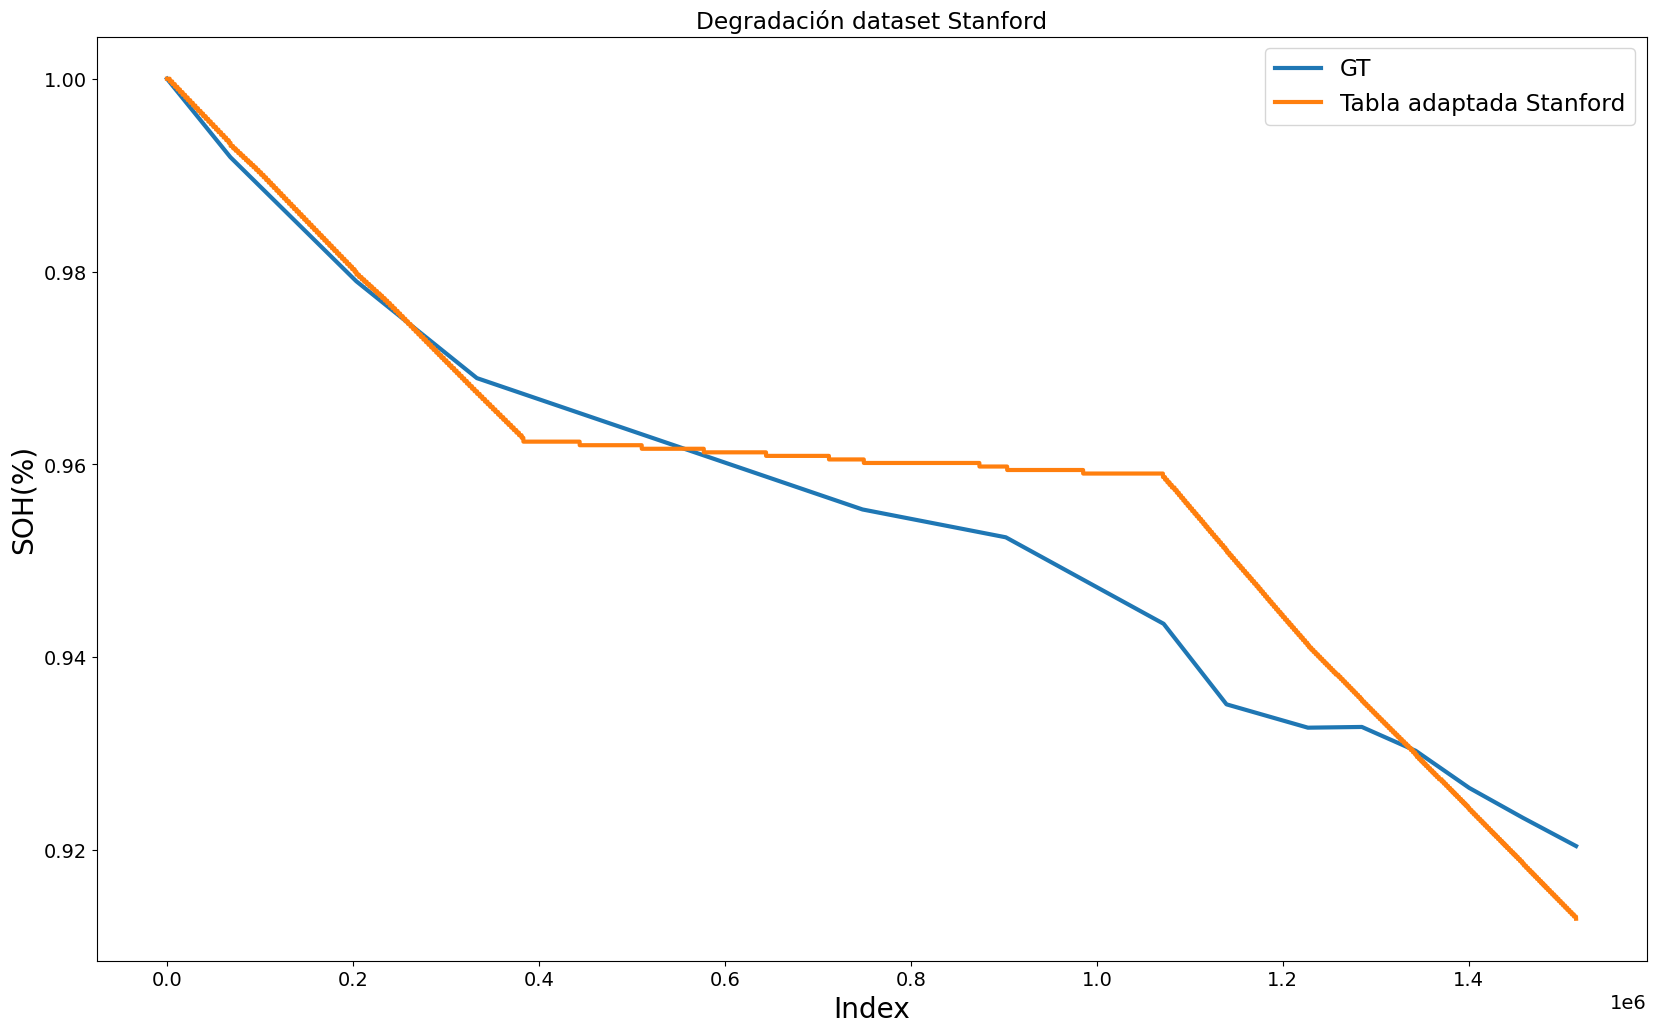

In [18]:
plt.figure(figsize=(20, 12))

plt.plot(gt_soh_idx,gt_soh_values, label="GT")
# plt.plot(lineal, label='Metodo lineal')
# plt.plot(maxmin, label='Metodo maxmin')
# plt.plot(aramis, label='Tabla original Aramis')
plt.plot(adap, label='Tabla adaptada Stanford')
# plt.plot(lineal, label='Tabla lineal')
# plt.plot(subc, label='Actualización por subciclo')

plt.title("Degradación dataset Stanford")
plt.xlabel("Index")
plt.ylabel("SOH(%)")
plt.legend()
plt.show()

In [19]:
error = gt_soh_values[-1] - adap[-1]
np.round(error*100,2)

0.75

### Guardamos los resultados del experimento

In [20]:
filename = 'adap_discharge_profile.csv'
data = adap
# Writing to a CSV file
with open(filename, 'w', newline='') as csvfile:
    csvwriter = csv.writer(csvfile)
    for item in data:
        csvwriter.writerow([item])

print(f"Data saved to {filename}")

Data saved to adap_discharge_profile.csv


### Importamos los datos para comparar

In [33]:
filename = 'adap_discharge_profile.csv'
# Leer el archivo CSV
with open(filename, newline='') as csvfile:
    csvreader = csv.reader(csvfile)
    adap_discharge_profile = [float(row[0]) for row in csvreader]
filename = 'adap_full_profile.csv'
# Leer el archivo CSV
with open(filename, newline='') as csvfile:
    csvreader = csv.reader(csvfile)
    adap_full_profile = [float(row[0]) for row in csvreader]

In [32]:
adap[32000]

0.9969435218494279

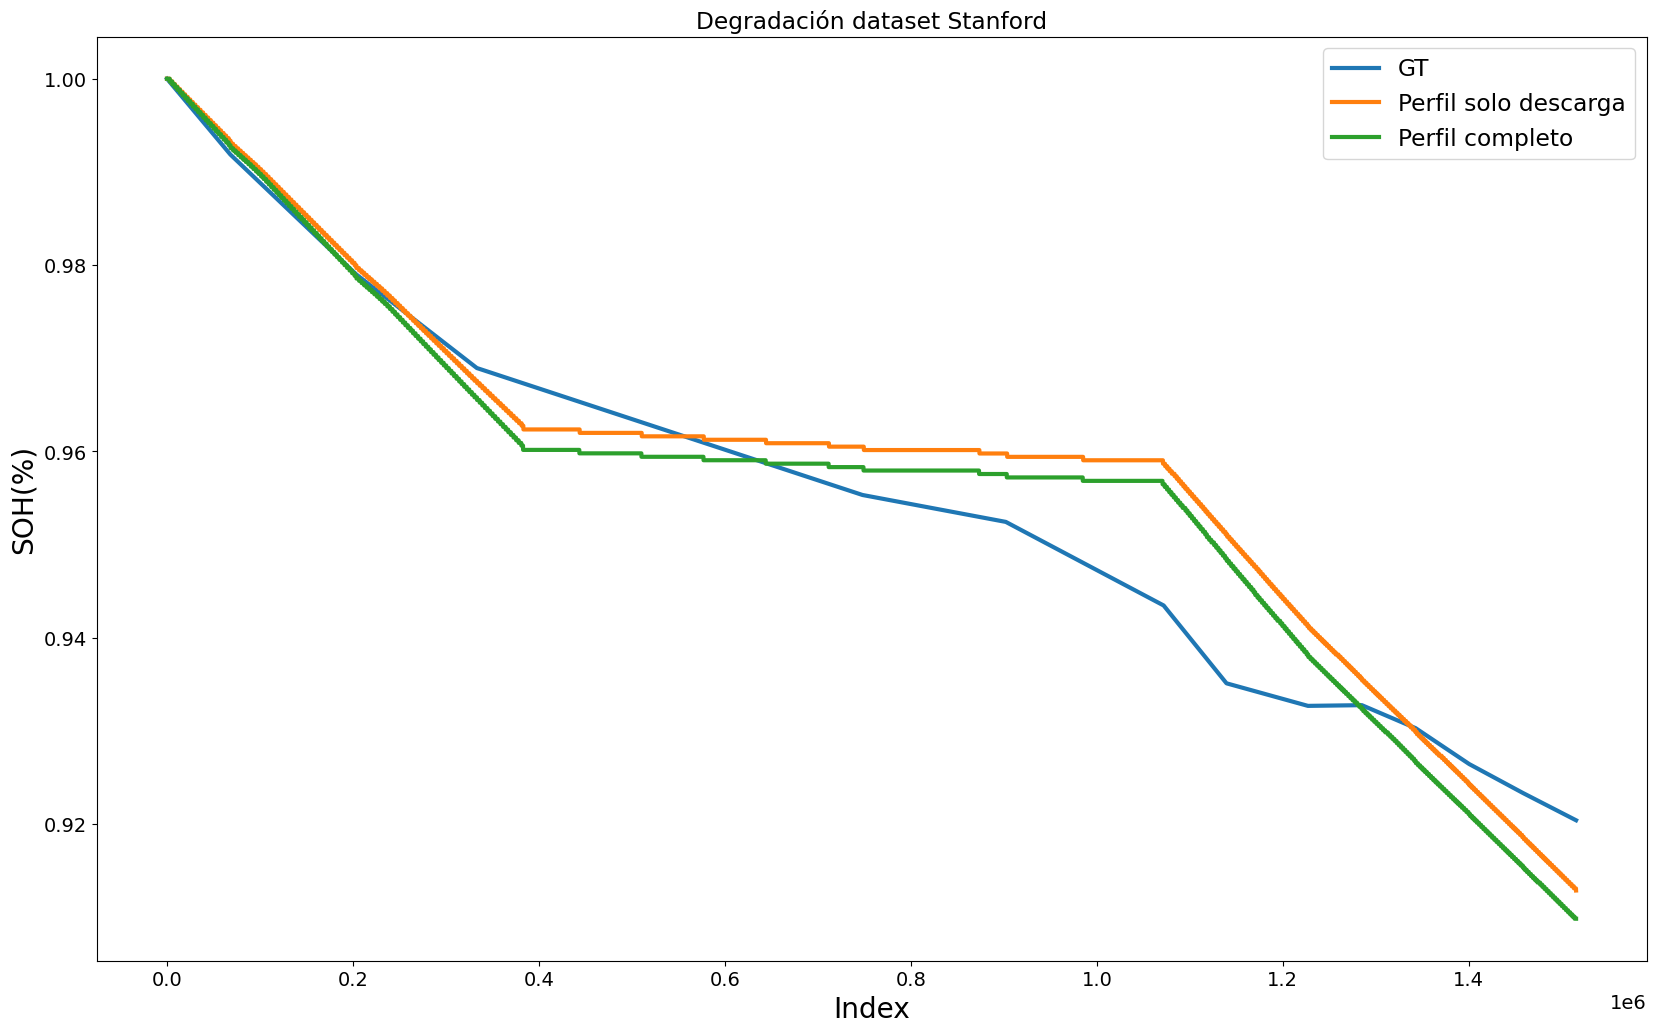

In [35]:
plt.figure(figsize=(20, 12))

plt.plot(gt_soh_idx,gt_soh_values, label="GT")
# plt.plot(lineal, label='Metodo lineal')
# plt.plot(maxmin, label='Metodo maxmin')
# plt.plot(aramis, label='Tabla original Aramis')
plt.plot(adap_discharge_profile, label='Perfil solo descarga')
plt.plot(adap_full_profile, label='Perfil completo')
# plt.plot(lineal, label='Tabla lineal')
# plt.plot(subc, label='Actualización por subciclo')

plt.title("Degradación dataset Stanford")
plt.xlabel("Index")
plt.ylabel("SOH(%)")
plt.legend()
plt.show()

### Sacamos el error por cada diagnóstico